In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.nn.functional import log_softmax, pad
import copy
import gc
import torch.optim as optim
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#calibration
def calibration(preds, actuals, groupsize = 30000, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, actual, 'k.')
    plt.plot(predicted, predicted, 'r--')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

## Data

In [4]:
#function to clean and organize data from statcast
def organize_data(df):

    df = df.loc[df.balls < 4]
    df = df.loc[df.strikes < 3]

    df.dropna(subset = ['release_extension',
                      'release_speed','release_spin_rate', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z'], axis = 0,
            inplace = True)

    #convert movement to inches instead of feet
    df[['mx', 'mz']] = df[['pfx_x', 'pfx_z']].values * 12

    #one hot encode handedness
    pit_hand = pd.get_dummies(df['p_throws'], drop_first = False, dtype = int)
    bat_hand = pd.get_dummies(df['stand'], drop_first = False, dtype = int)
    df['pit_handR'] = pit_hand['R']
    df['bat_handR'] = bat_hand['R']
    df = df.drop(['p_throws', 'stand', 'pfx_x', 'pfx_z'], axis = 1)

    #remove bunts
    df = df.loc[df.description.isin(['foul_bunt', 'bunt_foul_tip', 'missed_bunt']) == False]
    df = df.loc[df.events != 'sac_bunt']

    #define the pitch outcome
    df['outcome'] = -1
    df.loc[df.type == 'B', 'outcome'] = 0 #called ball
    df.loc[df.description == 'called_strike', 'outcome'] = 1 #called strike
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'outcome'] = 2 #swm
    df.loc[df.description.isin(['foul', 'foul_tip']), 'outcome'] = 3 #foul ball

    #the other outcomes are all batted balls, which should either be outs or singles, doubles, triples, or home runs
    df.loc[(df.type == 'X') & (df.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice',
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play',
                                               'sac_fly_double_play'])), 'outcome'] = 4 # in play out
    df.loc[(df.type == 'X') & (df.events == 'single'), 'outcome'] = 5 #single
    df.loc[(df.type == 'X') & (df.events == 'double'), 'outcome'] = 6 # double
    df.loc[(df.type == 'X') & (df.events == 'triple'), 'outcome'] = 7 #triple
    df.loc[(df.type == 'X') & (df.events == 'home_run'), 'outcome'] = 8 #hr

    #if outcome is still -1, drop it
    df = df.loc[df.outcome != -1]

    #define an is_swing column
    df['is_swing'] = -1
    df.loc[df.description.isin(['hit_into_play', 'foul', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip']), 'is_swing'] = 1
    df.loc[df.description.isin(['called_strike', 'ball', 'blocked_ball', 'hit_by_pitch', 'pitchout']), 'is_swing'] = 0

    #define an is_miss column
    df['is_miss'] = -1
    df.loc[df.is_swing == 0 , 'is_miss'] = 0
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'is_miss'] = 1
    df.loc[df.description.isin(['hit_into_play', 'foul', 'foul_tip']), 'is_miss'] = 0
    return df

In [5]:
#read in the data
needed_columns = ['game_date', 'game_year', 'game_pk', 'player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_name', 'stand', 'p_throws', 'balls', 'strikes', 'release_speed',
                  'release_spin_rate', 'release_extension', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
                  'plate_x', 'plate_z',  'type', 'events', 'description', 'woba_value', 'at_bat_number', 'pitch_number']

raw22 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw22.csv')
raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw21.csv')
raw21 = raw21[needed_columns]
raw22 = raw22[needed_columns]

#clean the data

df21 = organize_data(raw21)
df22 = organize_data(raw22)


all_data = pd.concat((df21, df22), ignore_index = True)

In [6]:
#min max scale variables
standardizer = StandardScaler().fit(all_data[['release_speed', 'mx', 'mz',
     'plate_x', 'plate_z',  'release_spin_rate']].values)

all_data[['release_speed', 'mx', 'mz',
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.transform(all_data[['release_speed', 'mx', 'mz',
     'plate_x', 'plate_z', 'release_spin_rate']].values)

#get the batter index
batter_indices = pd.DataFrame({'batter': all_data.batter.unique()})

batter_indices['batter_index'] = batter_indices.index.values

#merge
all_data = all_data.merge(batter_indices, on = 'batter')

In [7]:
#data set class
class DataSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

features = ['balls', 'strikes', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z',
                'mx', 'mz', 'pit_handR', 'bat_handR', 'batter_index']

train, test = train_test_split(all_data, train_size = 0.7)

train_x = train[features].values
train_y = train.outcome.values
test_x = test[features].values
test_y = test.outcome.values

trainset = DataSet(train_x, train_y)
testset = DataSet(test_x, test_y)

#dataloaders
trainloader = DataLoader(trainset, batch_size = 256, shuffle = True)
testloader = DataLoader(testset, batch_size = 256, shuffle = True)

## NNet

This neural network structure is pretty similar to the original optimus pitch only the hidden state is removed, so it's just a function of the current pitch not the full sequence

In [8]:
batter_embedding_dim = 13

class OP(nn.Module):
    def __init__(self):
        super().__init__()
        #embedding
        self.batter_embedding = nn.Embedding(batter_indices.shape[0], embedding_dim = batter_embedding_dim)

        #layers
        self.l1 = nn.Linear(in_features = len(features) - 1 + batter_embedding_dim, out_features = 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 64)
        self.l5 = nn.Linear(64, 9)
        self.relu = nn.ReLU()

    def forward(self, x):
        #batter index is last column of x
        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        #concatenate batter embedding onto data
        conc = torch.concat((x[:,:-1], bat_emb), dim = 1)

        #run through network
        conc = self.relu(self.l1(conc))
        conc = self.relu(self.l2(conc))
        conc = self.relu(self.l3(conc))
        conc = self.relu(self.l4(conc))
        return self.l5(conc)

In [9]:
#training: hyperparameters
learning_rate = 1e-5
epochs = 20

model = OP().to(device)
model.batter_embedding.weight.data.fill_(.1)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_accs = []
test_accs = []

In [10]:
#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    num_correct =  0
    for batch, (x, y_truth) in enumerate(trainloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        outputs = model(x)
        #calculate loss
        loss = loss_fn(outputs, y_truth)
        loss_val += loss.item()
         #acc
        predicted = outputs.cpu().detach().numpy().argmax(axis = 1)
        num_correct += np.sum(predicted == y_truth.cpu().numpy())

        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(trainloader))
    train_accs.append(num_correct / (len(trainloader) * 256))

    loss_val = 0
    num_correct = 0
    for batch, (x, y_truth) in enumerate(testloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        preds = model(x)

        #loss
        loss = loss_fn(preds, y_truth)
        loss_val += loss.item()
        #acc
        predicted = preds.cpu().detach().numpy().argmax(axis = 1)
        num_correct += np.sum(predicted == y_truth.cpu().numpy())


    test_losses.append(loss_val/ len(testloader))
    test_accs.append(num_correct / (len(testloader) * 256))

    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

epoch : 1/20, loss = 1.533264
epoch : 2/20, loss = 1.232270
epoch : 3/20, loss = 1.200407
epoch : 4/20, loss = 1.186319
epoch : 5/20, loss = 1.177876
epoch : 6/20, loss = 1.171856
epoch : 7/20, loss = 1.167182
epoch : 8/20, loss = 1.163277
epoch : 9/20, loss = 1.159966
epoch : 10/20, loss = 1.157010
epoch : 11/20, loss = 1.154371
epoch : 12/20, loss = 1.151996
epoch : 13/20, loss = 1.149804
epoch : 14/20, loss = 1.147873
epoch : 15/20, loss = 1.146067
epoch : 16/20, loss = 1.144414
epoch : 17/20, loss = 1.142894
epoch : 18/20, loss = 1.141449
epoch : 19/20, loss = 1.140043
epoch : 20/20, loss = 1.138733


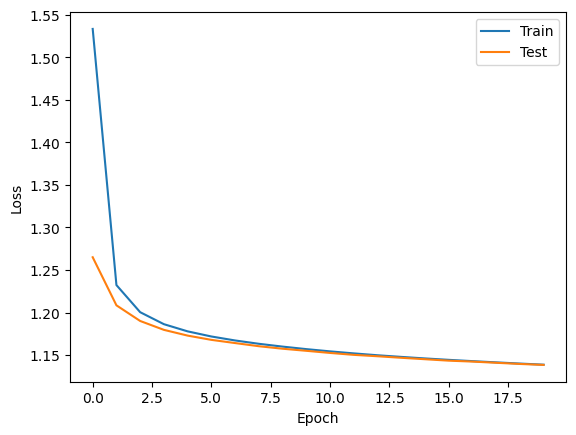

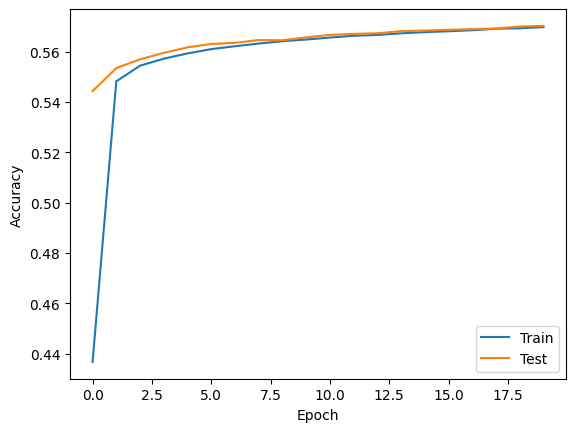

In [11]:
plt.plot(train_losses, label = 'Train')
plt.plot(test_losses, label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label = 'Train')
plt.plot(test_accs, label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
#calibration
train_preds = nn.functional.softmax(model(torch.tensor(train_x, dtype = torch.float32).to(device)), dim = -1).cpu().detach().numpy()
test_preds = nn.functional.softmax(model(torch.tensor(test_x, dtype = torch.float32).to(device)), dim = -1).cpu().detach().numpy()

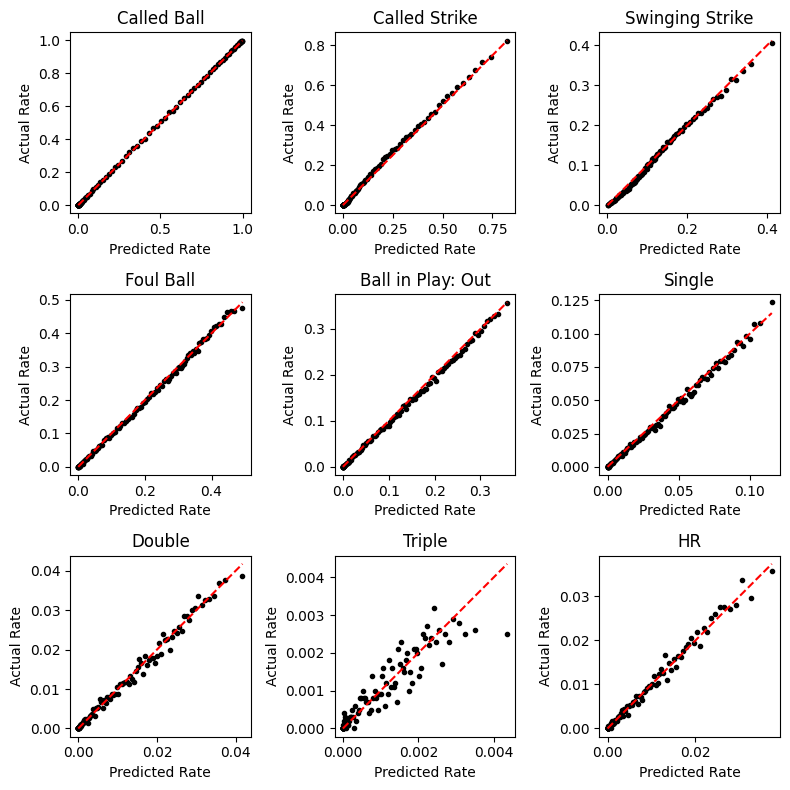

In [13]:
fig= plt.figure(figsize=(8,8))
ax1 = plt.subplot(331)
ax1 = calibration(train_preds[:,0], (train_y == 0).astype(bool).astype(int),10000, title = 'Called Ball')

ax2 = plt.subplot(332)
ax2 = calibration(train_preds[:,1], (train_y == 1).astype(bool).astype(int),10000, title = 'Called Strike')

ax3 = plt.subplot(333)
ax3 = calibration(train_preds[:,2], (train_y == 2).astype(bool).astype(int), 10000,title = 'Swinging Strike')

ax4 = plt.subplot(334)
ax4 = calibration(train_preds[:,3], (train_y == 3).astype(bool).astype(int),10000, title = 'Foul Ball')

ax5 = plt.subplot(335)
ax5 = calibration(train_preds[:,4], (train_y == 4).astype(bool).astype(int), 10000,title = 'Ball in Play: Out')

ax6 = plt.subplot(336)
ax6 = calibration(train_preds[:,5], (train_y == 5).astype(bool).astype(int), 10000,title = 'Single')

ax7 = plt.subplot(337)
ax7 = calibration(train_preds[:,6], (train_y == 6).astype(bool).astype(int),10000, title = 'Double')

ax8 = plt.subplot(338)
ax8 = calibration(train_preds[:,7], (train_y == 7).astype(bool).astype(int),10000, title = 'Triple')

ax9 = plt.subplot(339)
ax9 = calibration(train_preds[:,8], (train_y == 8).astype(bool).astype(int), 10000,title = 'HR')

plt.tight_layout()
plt.show()

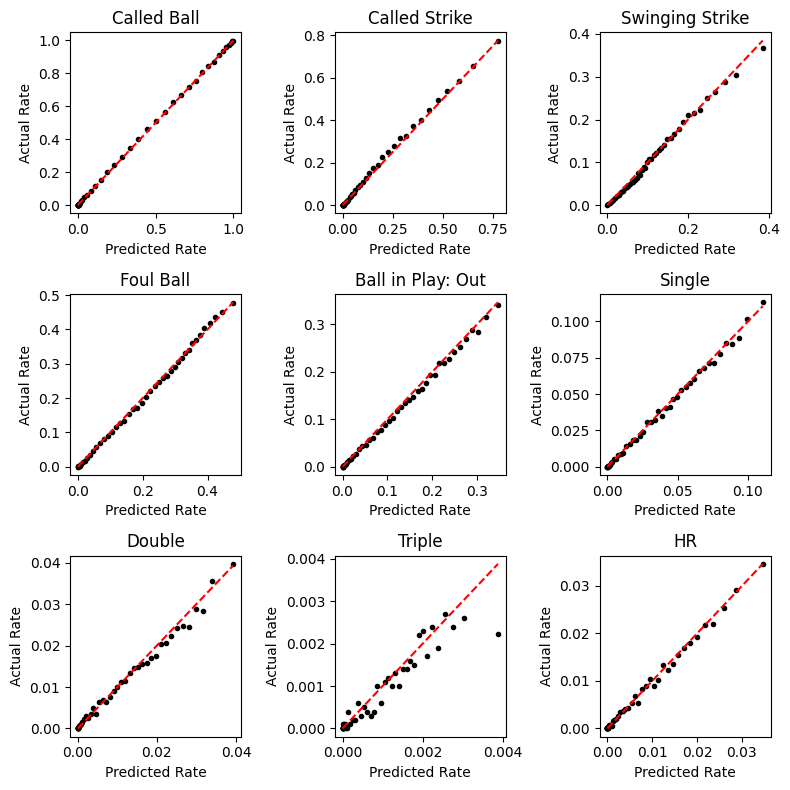

In [14]:
fig= plt.figure(figsize=(8,8))
ax1 = plt.subplot(331)
ax1 = calibration(test_preds[:,0], (test_y == 0).astype(bool).astype(int),10000, title = 'Called Ball')

ax2 = plt.subplot(332)
ax2 = calibration(test_preds[:,1], (test_y == 1).astype(bool).astype(int),10000, title = 'Called Strike')

ax3 = plt.subplot(333)
ax3 = calibration(test_preds[:,2], (test_y == 2).astype(bool).astype(int), 10000,title = 'Swinging Strike')

ax4 = plt.subplot(334)
ax4 = calibration(test_preds[:,3], (test_y == 3).astype(bool).astype(int),10000, title = 'Foul Ball')

ax5 = plt.subplot(335)
ax5 = calibration(test_preds[:,4], (test_y == 4).astype(bool).astype(int), 10000,title = 'Ball in Play: Out')

ax6 = plt.subplot(336)
ax6 = calibration(test_preds[:,5], (test_y == 5).astype(bool).astype(int), 10000,title = 'Single')

ax7 = plt.subplot(337)
ax7 = calibration(test_preds[:,6], (test_y == 6).astype(bool).astype(int),10000, title = 'Double')

ax8 = plt.subplot(338)
ax8 = calibration(test_preds[:,7], (test_y == 7).astype(bool).astype(int),10000, title = 'Triple')

ax9 = plt.subplot(339)
ax9 = calibration(test_preds[:,8], (test_y == 8).astype(bool).astype(int), 10000,title = 'HR')

plt.tight_layout()
plt.show()